In [20]:
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
#torch.set_num_threads(1)

sys.path.insert(0, '../../')
import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers

import glob

In [21]:
%matplotlib inline

In [22]:
data ={}

In [23]:
data_dir="data_old/"
files = glob.glob(data_dir+"*.gzip")
#print(files)

In [24]:
model="CW"
hh=0.
JJ=1.
Ns=[10, 20, 50, 100, 200]
net_specs = ["exact"]
data_exact={}
for N in Ns:
    data_exact[N] = pd.DataFrame()
    for net_spec in net_specs:
        name_f = f"_model{model}_net_spec{net_spec}_N{N}_J{JJ:.2}_h{hh:.2}.gzip"
        res = [i for i in files if name_f in i]
        if len(res) >= 1:
            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data_exact[N] = pd.concat([data_exact[N], df_], ignore_index=True)
            print(f"read: {res[0]}")
        else:
            print(res)

read: data_old/20221205-145007_86282_modelCW_net_specexact_N10_J1.0_h0.0.gzip
read: data_old/20221205-173101_90663_modelCW_net_specexact_N20_J1.0_h0.0.gzip
read: data_old/20221205-145052_68735_modelCW_net_specexact_N50_J1.0_h0.0.gzip
read: data_old/20221205-145102_66145_modelCW_net_specexact_N100_J1.0_h0.0.gzip
read: data_old/20221205-225738_62028_modelCW_net_specexact_N200_J1.0_h0.0.gzip


In [25]:
net_specs = ["one", "sum_exp", "sp2", "sp4", "sum_exp_exact", "MADE", "MADE_21", "MADE_22", "SL", "CW_sign" ]
data={}
for N in Ns:
    data[N] = pd.DataFrame()
    for net_spec in net_specs:
        name_f = f"_model{model}_net_spec{net_spec}_N{N}_J{JJ:.2}_h{hh:.2}.gzip"
        res = [i for i in files if name_f in i]
        if len(res) >= 1:
            def repl(name_col):
                return name_col.replace(net_spec, "")
            df_ = pd.read_pickle(res[0])
            df_ = df_.rename(repl, axis='columns')
            data[N] = pd.concat([data[N], df_], ignore_index=True)
            print(f"read: {res[0]}")
        else:
            print(res)

read: data_old/20221205-150601_80256_modelCW_net_specone_N10_J1.0_h0.0.gzip
read: data_old/20221205-152733_26709_modelCW_net_specsum_exp_N10_J1.0_h0.0.gzip
read: data_old/20221205-154724_68484_modelCW_net_specsp2_N10_J1.0_h0.0.gzip
read: data_old/20221205-160822_97818_modelCW_net_specsp4_N10_J1.0_h0.0.gzip
read: data_old/20221205-161109_82821_modelCW_net_specsum_exp_exact_N10_J1.0_h0.0.gzip
read: data_old/20221205-162651_60533_modelCW_net_specMADE_N10_J1.0_h0.0.gzip
read: data_old/20221205-164913_31745_modelCW_net_specMADE_21_N10_J1.0_h0.0.gzip
read: data_old/20221205-171234_08731_modelCW_net_specMADE_22_N10_J1.0_h0.0.gzip
read: data_old/20221205-173059_98438_modelCW_net_specSL_N10_J1.0_h0.0.gzip
read: data_old/20221208-122228_35851_modelCW_net_specCW_sign_N10_J1.0_h0.0.gzip
read: data_old/20221205-174902_38958_modelCW_net_specone_N20_J1.0_h0.0.gzip
read: data_old/20221205-182042_58845_modelCW_net_specsum_exp_N20_J1.0_h0.0.gzip
read: data_old/20221205-184246_42433_modelCW_net_specsp2_N

In [26]:
data[10].iloc[0]["beta"]

0.010000000000000002

In [27]:
for N in Ns:
    print(N)
    data[N]["err_fe"] = 0
    data[N]["err_fe_rel"] = 0
    to_set = []
    to_set_res = []
    for i in range(len(data[N])):
        beta =  data[N].iloc[i]["beta"]
        fe_ex = data_exact[N][np.abs(data_exact[N]["beta"]-beta)<1e-6]["free_energy"].item()
        #print(beta, fe_ex)
        to_set.append(np.abs(data[N].iloc[i]["free_energy_mean"].item() - fe_ex))
        to_set_res.append(np.abs(to_set[-1] / fe_ex))
    data[N]["err_fe"] = to_set
    data[N]["err_fe_rel"] = to_set_res


10
20
50
100
200


In [28]:
data[50][-10:]

,beta,free_energy_mean,free_energy_std,entropy_mean,energy_mean,mag,mag_mean,num_params,num_train_params,save_dir,...,lr,std_fe_limit,max_step,batch_size,batch_iter,stats_step,num_threads,beta_range,err_fe,err_fe_rel
1990,1.91,-0.510932,0.000190,0.145195,-0.434913,-0.002377,0.941709,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",2.025788e-06,3.964875e-06
1991,1.92,-0.510537,0.000174,0.143230,-0.435938,0.004813,0.942831,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",2.971560e-06,5.820424e-06
1992,1.93,-0.510156,0.000183,0.140496,-0.437360,0.001695,0.944405,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",9.038331e-07,1.771677e-06
1993,1.94,-0.509780,0.000159,0.138044,-0.438624,-0.002835,0.945759,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",3.226238e-06,6.328642e-06
1994,1.95,-0.509417,0.000157,0.136437,-0.439450,-0.007927,0.946667,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",2.729988e-06,5.359010e-06
1995,1.96,-0.509066,0.000183,0.135025,-0.440175,-0.002481,0.947463,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",4.479243e-07,8.798943e-07
1996,1.97,-0.508719,0.000146,0.133070,-0.441171,0.000742,0.948564,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",1.946157e-06,3.825587e-06
1997,1.98,-0.508385,0.000150,0.129677,-0.442891,-0.000687,0.950439,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",4.633300e-07,9.113762e-07
1998,1.99,-0.508056,0.000137,0.128120,-0.443675,-0.003141,0.951289,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",1.172329e-06,2.307473e-06
1999,2.00,-0.507738,0.000139,0.124711,-0.445383,-0.007352,0.953134,100,100,results/Curie-Weiss/data/,...,0.001,0.0001,100,2000,20,1,1,"[0.01, 2.0, 200.0]",3.835426e-07,7.553940e-07


(0.0, 0.004)

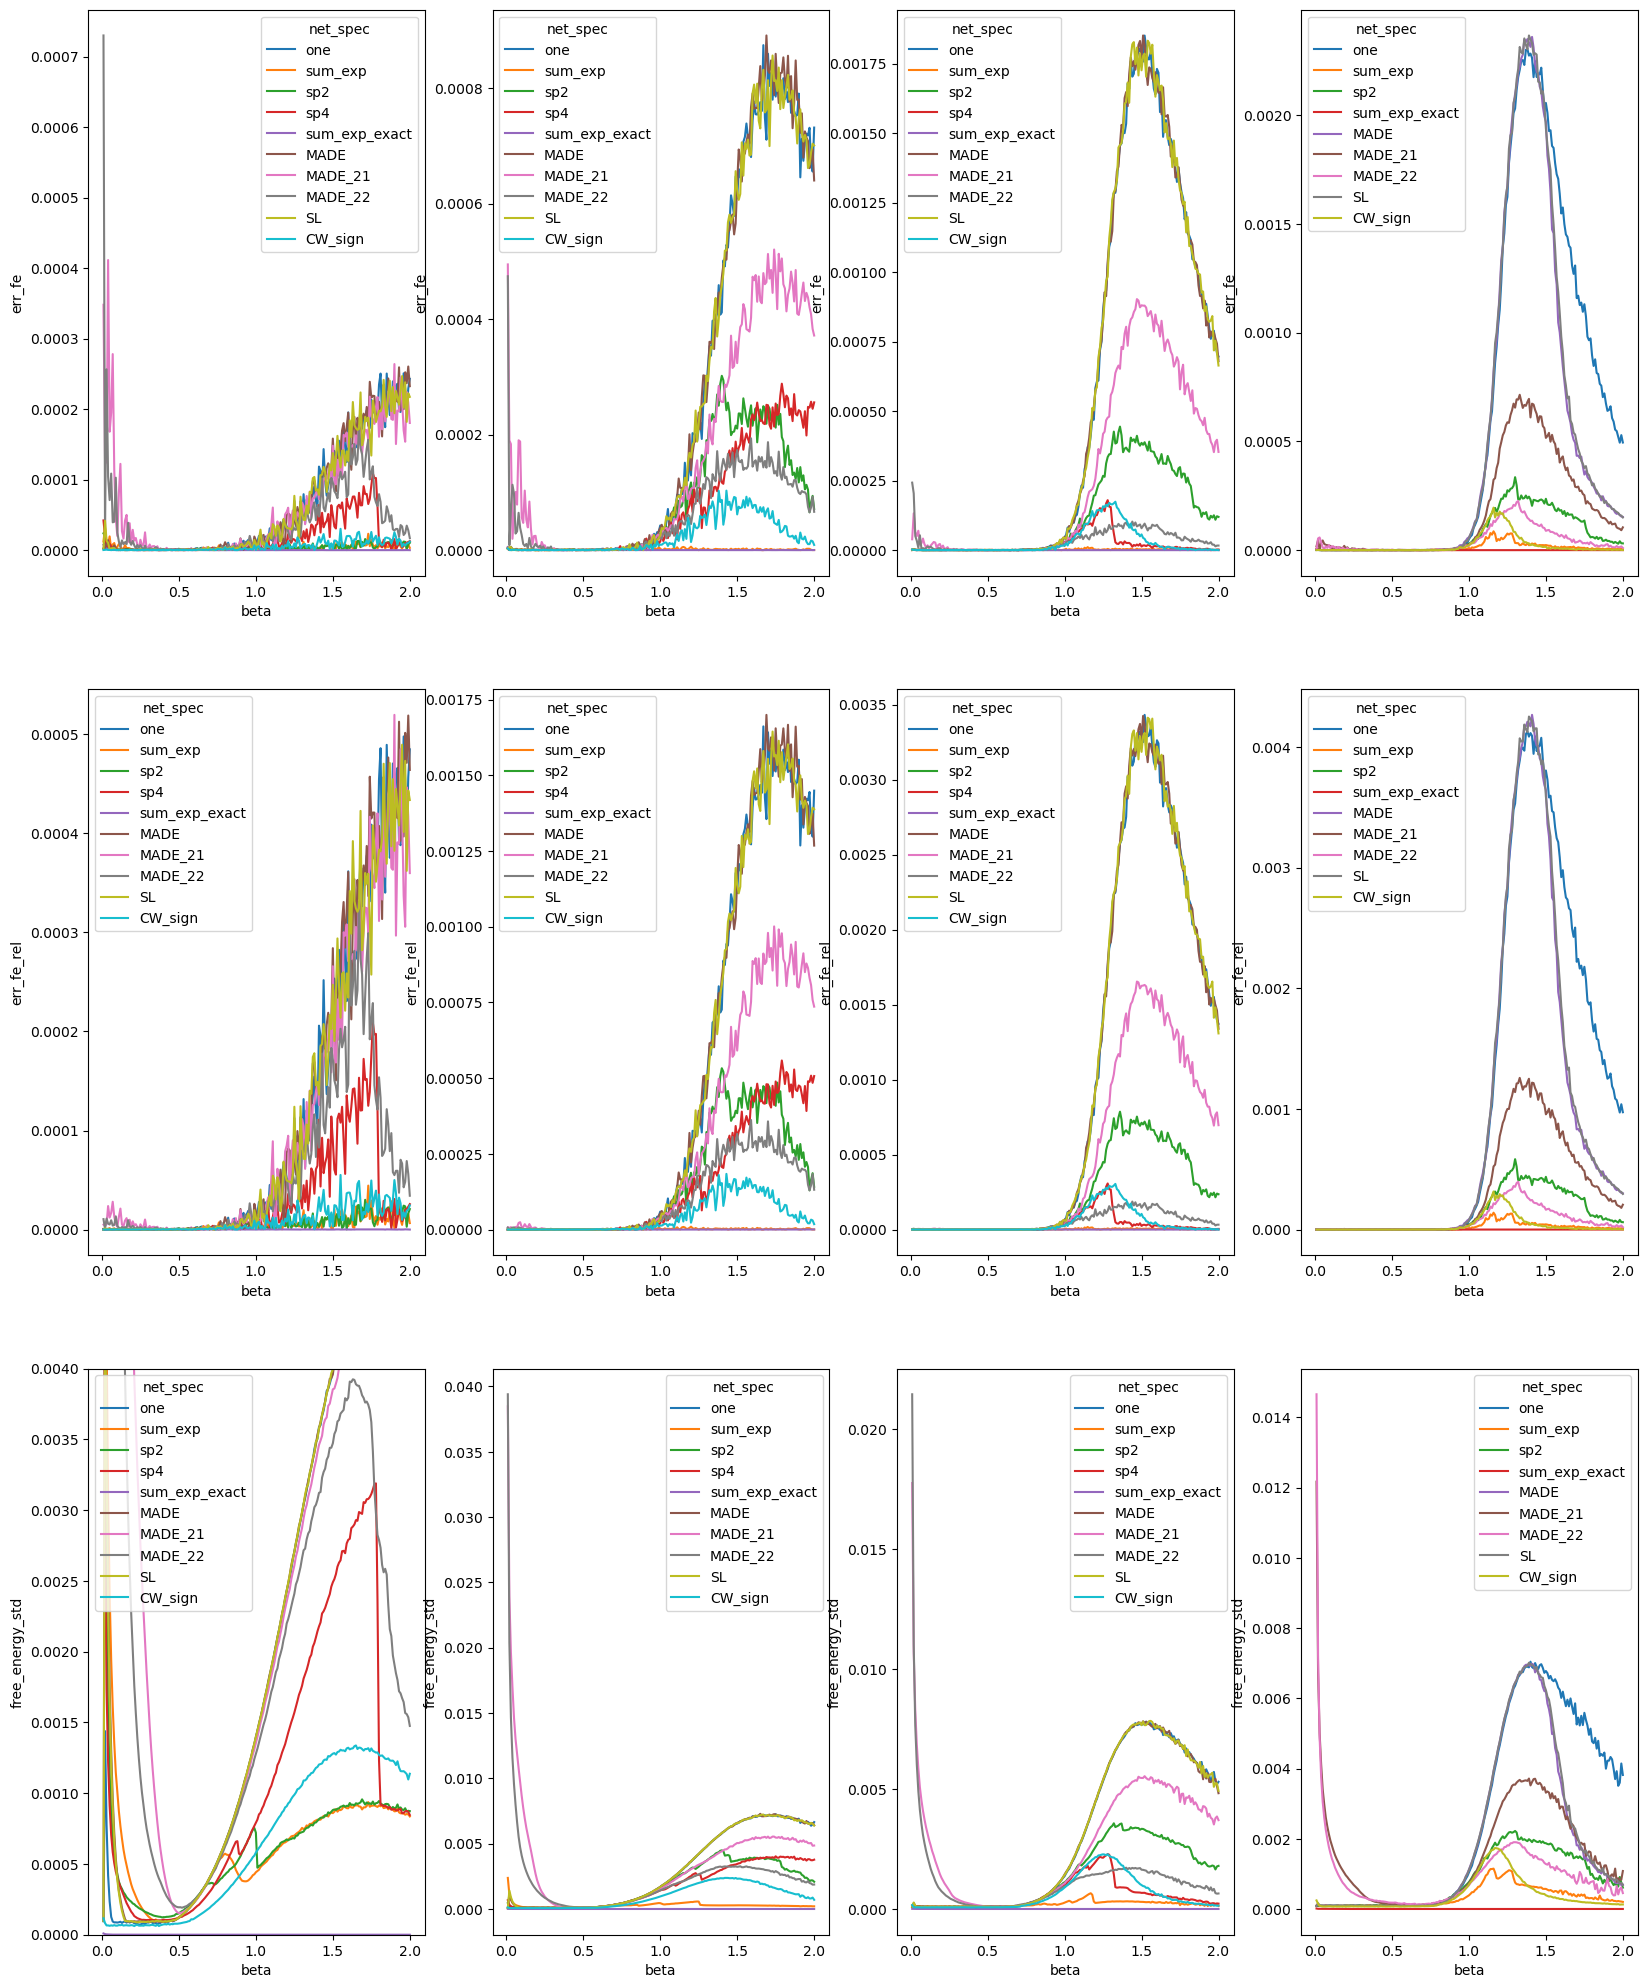

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,4, figsize=(20, 25))
N=10
#dd = data[N].rolling(5, on="beta").mean()
sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
N=20
sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][1])
N=50
sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][2])
N=100
sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][3])

N=10
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
N=20
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][1])
N=50
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][2])
N=100
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][3])

N=10
sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][0])
N=20
sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][1])
N=50
sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][2])
N=100
sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][3])
axs[2][0].set_ylim(0,0.004)


<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

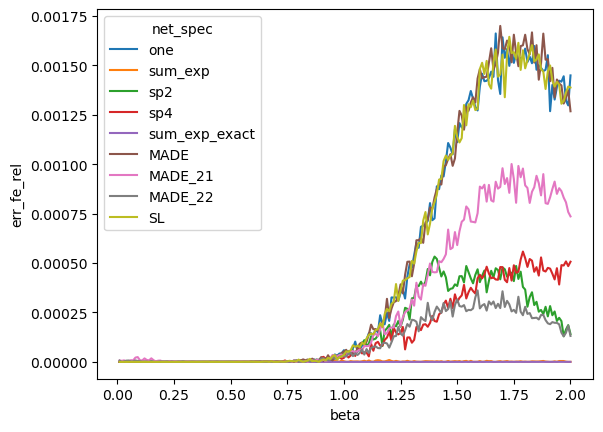

In [58]:
import seaborn as sns
N=20
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

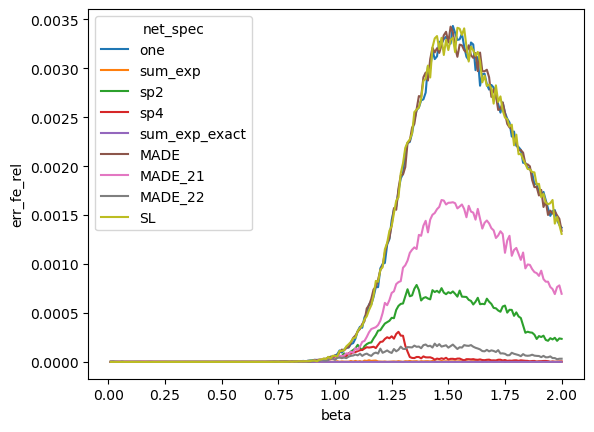

In [56]:
import seaborn as sns
N=50
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

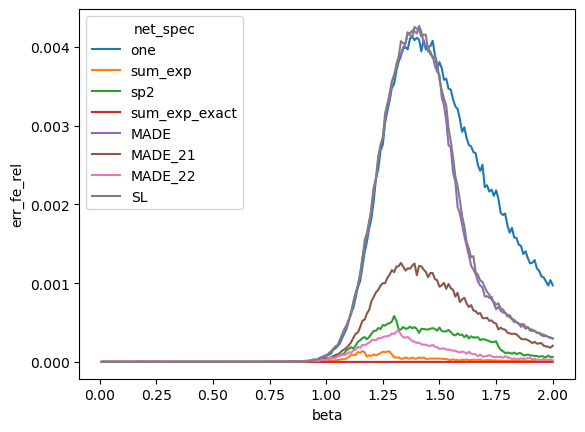

In [57]:
import seaborn as sns
N=100
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

In [28]:
data[10]

,beta,free_energy,free_energy_std,mag_mean,save_dir,file_name,model,net_spec,device,suffix,...,batch_iter,stats_step,num_threads,beta_range,free_energy_mean,entropy_mean,energy_mean,mag,num_params,num_train_params
0,0.01,-69.314944,0.000000,0.248303,results/Curie-Weiss/data/,data,CW,exact,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",NaN,NaN,NaN,NaN,NaN,NaN
1,0.02,-34.657814,0.000000,0.249551,results/Curie-Weiss/data/,data,CW,exact,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",NaN,NaN,NaN,NaN,NaN,NaN
2,0.03,-23.105592,0.000000,0.250815,results/Curie-Weiss/data/,data,CW,exact,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",NaN,NaN,NaN,NaN,NaN,NaN
3,0.04,-17.329599,0.000000,0.252093,results/Curie-Weiss/data/,data,CW,exact,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",NaN,NaN,NaN,NaN,NaN,NaN
4,0.05,-13.864099,0.000000,0.253388,results/Curie-Weiss/data/,data,CW,exact,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.96,NaN,0.004807,0.905210,results/Curie-Weiss/data/,data,CW,SL,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",-0.503581,0.248837,-0.376623,0.00589,110.0,110.0
1996,1.97,NaN,0.004841,0.906230,results/Curie-Weiss/data/,data,CW,SL,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",-0.502903,0.247070,-0.377487,-0.00239,110.0,110.0
1997,1.98,NaN,0.004791,0.908950,results/Curie-Weiss/data/,data,CW,SL,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",-0.502332,0.243766,-0.379218,-0.00315,110.0,110.0
1998,1.99,NaN,0.004764,0.911640,results/Curie-Weiss/data/,data,CW,SL,cpu,None,...,20,1,1,"[0.01, 2.0, 200.0]",-0.501678,0.239506,-0.381323,-0.00228,110.0,110.0


In [20]:
N=20
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=50
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=50
batch_size=2000
std_fe_limit=1e-4
lr=0.0005
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=100
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")


In [21]:
data.keys()

dict_keys(['CW_N20_bs2000_fe_lim0.0001_lr0.001', 'CW_N50_bs2000_fe_lim0.0001_lr0.001', 'CW_N50_bs2000_fe_lim0.0001_lr0.0005', 'CW_N100_bs2000_fe_lim0.0001_lr0.001'])

<AxesSubplot:xlabel='beta'>

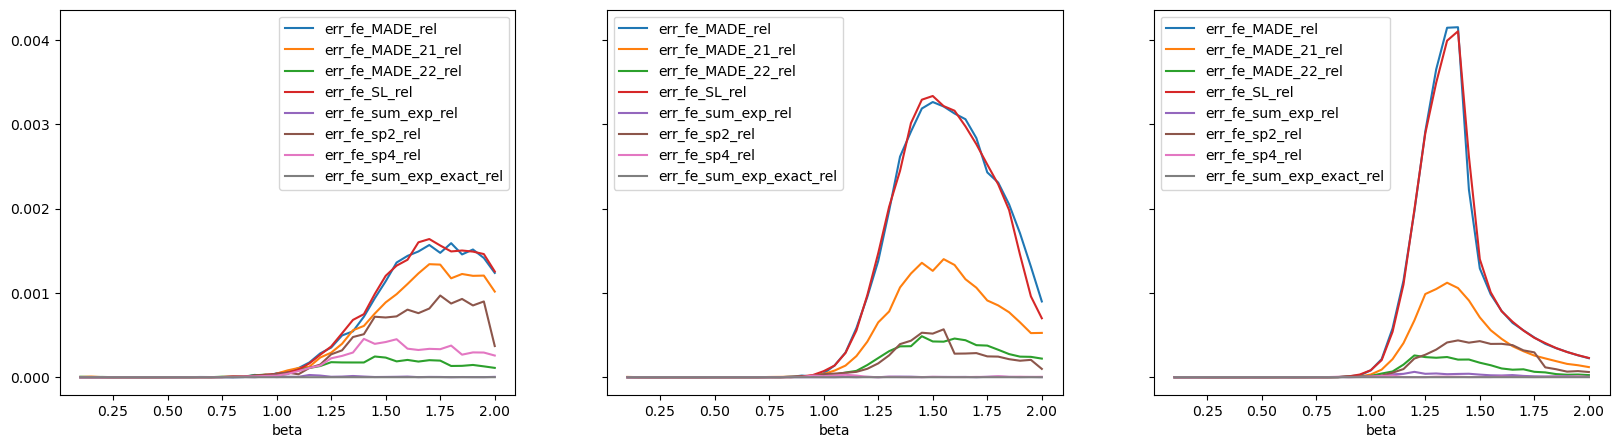

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)
data

name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data['CW_N20_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[0])
data['CW_N50_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[1])
data['CW_N100_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[2])

<AxesSubplot:xlabel='beta'>

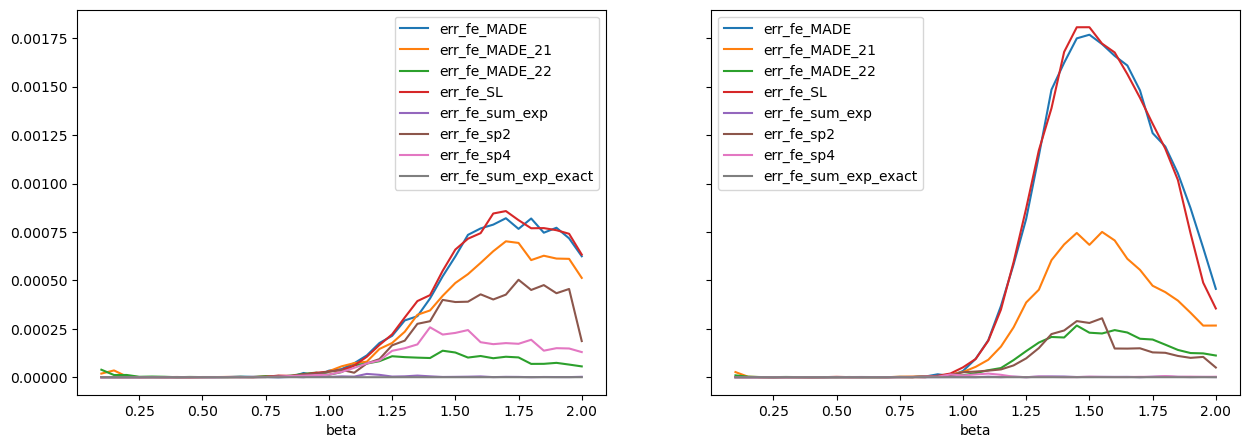

In [23]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)
data

name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}" for x in name_nets]
#namess.append("free_energy_std")
data['CW_N20_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[0])
data['CW_N50_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[1])

# Curie Weiss

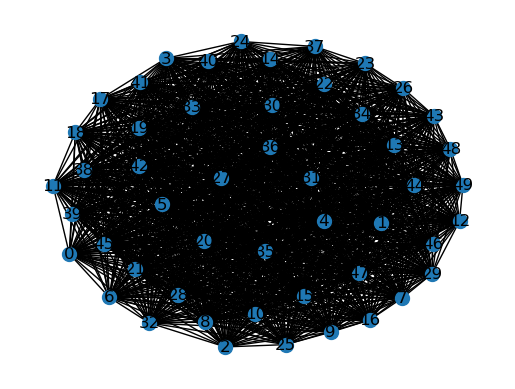

In [3]:
import importlib
import matplotlib.pyplot as plt

N = 50
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))

if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)
JJ=1
J_val = JJ/(2*N)
J = J_val * J_interaction

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.
Th. results

In [4]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

device="cpu"
#device="mps"
CW_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=2

beta_init = 0.1
step = 0.05
betas = np.arange(beta_init, beta_fin+step, step)

In [5]:
from python_lib.models import spins_model
importlib.reload(spins_model)

CW_model_exact = spins_model.KW_exact_fast(N, H, J, J_interaction, device="cpu")
f_exact = []
f_exact_infN = []
for beta_ in betas:
    f_exact.append(CW_model_exact.exact(beta_))
    f_exact_infN.append(CW_model_exact.exact_infN(beta_))

In [6]:
f_exact_infN[0]

{'beta': 0.1,
 'free_energy': -6.931021827284194,
 'free_energy_std': 0,
 'mag_mean': 0.009999666456504392}

In [7]:
CW_model_exact.H[0].item()

0.0

In [8]:
data_exact = pd.DataFrame(f_exact)
f_exact_infN_pd = pd.DataFrame(f_exact_infN)
f_exact_infN_pd = f_exact_infN_pd.add_suffix("_inf")


In [9]:
data = data_exact
data = pd.concat([data, f_exact_infN_pd], axis = 1)


In [10]:
data

,beta,free_energy,free_energy_std,mag_mean,beta_inf,free_energy_inf,free_energy_std_inf,mag_mean_inf
0,0.10,-6.931996,0,0.118328,0.10,-6.931022,0,0.010000
1,0.15,-4.621795,0,0.121727,0.15,-4.620344,0,0.014999
2,0.20,-3.466862,0,0.125422,0.20,-3.464936,0,0.019997
3,0.25,-2.774052,0,0.129456,0.25,-2.771651,0,0.024995
4,0.30,-2.312320,0,0.133882,0.30,-2.309441,0,0.029991
5,0.35,-1.982648,0,0.138765,0.35,-1.979284,0,0.034986
6,0.40,-1.735531,0,0.144186,0.40,-1.731669,0,0.039979
7,0.45,-1.543469,0,0.150243,0.45,-1.539090,0,0.044970
8,0.50,-1.389967,0,0.157061,0.50,-1.385045,0,0.049958
9,0.55,-1.264532,0,0.164800,0.55,-1.259031,0,0.054945


In [11]:
data.dtypes

beta                   float64
free_energy            float64
free_energy_std          int64
mag_mean               float64
beta_inf               float64
free_energy_inf        float64
free_energy_std_inf      int64
mag_mean_inf           float64
dtype: object

<AxesSubplot:xlabel='beta'>

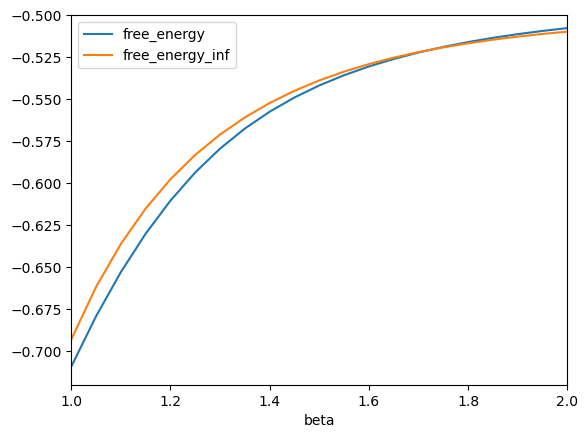

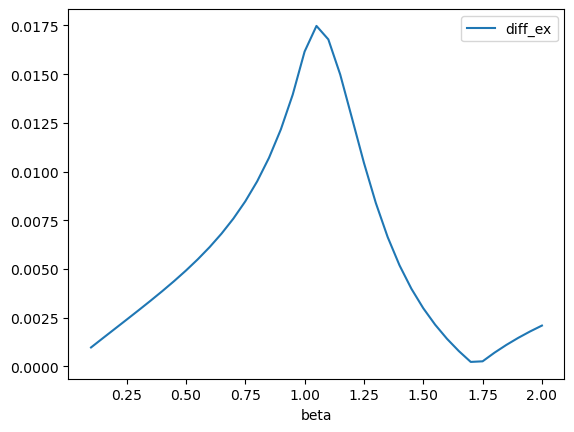

In [12]:
data.plot(x="beta", y= ["free_energy", "free_energy_inf"], ylim=[-0.72,-0.5], xlim=[1,2])
data["diff_ex"] = np.abs(data["free_energy"]- data[ "free_energy_inf"])
data.plot(x="beta", y= "diff_ex")


# Several cases

In [13]:
lr = 0.001
max_step=1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20

In [14]:
from python_lib.nets import list_nets
importlib.reload(list_nets)
import python_lib.nets.ann
importlib.reload(python_lib.nets.ann)
from python_lib import run_lib
importlib.reload(run_lib);

In [15]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, bias=True, device=device)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 2550
Total Params: 2550
step: 0 2.00 fe: -0.507 +- 0.00335 E: -0.447, S: 0.121, M: 0.954953

In [16]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=1
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_21",
    batch_iter=batch_iter,
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5150
Total Params: 5150
step: 0 2.00 fe: -0.508 +- 0.00172 E: -0.446, S: 0.123, M: 0.954953

In [17]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=2
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_22",
    batch_iter=batch_iter,
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 10250
Total Params: 10250
step: 0 2.00 fe: -0.508 +- 0.00166 E: -0.444, S: 0.128, M: 0.951952

In [18]:
from python_lib.nets import simple_layer
import importlib
importlib.reload(simple_layer)
net2train = simple_layer.simple_layer(CW_model, bias=True, device=device)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SL",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 2550
Total Params: 2550
step: 0 2.00 fe: -0.507 +- 0.00188 E: -0.448, S: 0.118, M: 0.956954

In [19]:
# from python_lib.nets import ann
# importlib.reload(ann)

# from python_lib.nets import list_nets
# importlib.reload(list_nets)

# one = list_nets.one_var
# input_mask = torch.tril(J_interaction, diagonal=-1)
# input_mask = input_mask.to(dtype=torch.bool)
# dict_nets = {}
# net2train = list_nets.list_nets(CW_model, one, input_mask, device=device, dict_nets=dict_nets)
# res = run_lib.train_net(net2train, betas,
#     lr = lr,
#     max_step=max_step,
#     batch_size=batch_size,
#     std_fe_limit=std_fe_limit,
#     suffix ="_one",
#     batch_iter=batch_iter
# )
# data = pd.concat([data, res], axis = 1)


In [20]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sum_exp_exact",
    exact=True,
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5294
Total Params: 5294
step: 0 2.00 fe: -0.508 +- 0.00000 E: -0.445, S: 0.125, M: 0.953

In [21]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sum_exp",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5294
Total Params: 5294
step: 0 2.00 fe: -0.508 +- 0.00021 E: -0.445, S: 0.126, M: 0.952538

In [22]:
# from python_lib.nets import list_nets
# importlib.reload(list_nets)

# list_n = list_nets.CW_net_sp
# input_mask = torch.tril(J_interaction, diagonal=-1)
# input_mask = input_mask.to(dtype=torch.bool)
# dict_nets = {"num_extremes": 1}
# net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
# res = run_lib.train_net(net2train, betas,
#     lr = lr,
#     max_step=max_step,
#     batch_size=batch_size,
#     std_fe_limit=std_fe_limit,
#     suffix ="_sp",
#     batch_iter=batch_iter
# )
# data = pd.concat([data, res], axis = 1)


In [23]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net_sp
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"num_extremes": 2}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sp2",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 982
Total Params: 982
step: 0 2.00 fe: -0.508 +- 0.00111 E: -0.445, S: 0.126, M: 0.953953

In [24]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net_sp
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"num_extremes": 4}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sp4",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 1766
Total Params: 1766
step: 0 2.00 fe: -0.508 +- 0.00040 E: -0.445, S: 0.125, M: 0.953532

In [25]:
data["beta"] = betas

In [26]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]

for kk in name_nets:
    data[f"err_fe{kk}"] = np.abs(data[f"free_energy_mean{kk}"] - data["free_energy"])
    data[f"err_fe{kk}_rel"] = np.abs((data[f"err_fe{kk}"] / data["free_energy"]))


In [27]:
data.to_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

In [ ]:
data.read.csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

<AxesSubplot:xlabel='beta'>

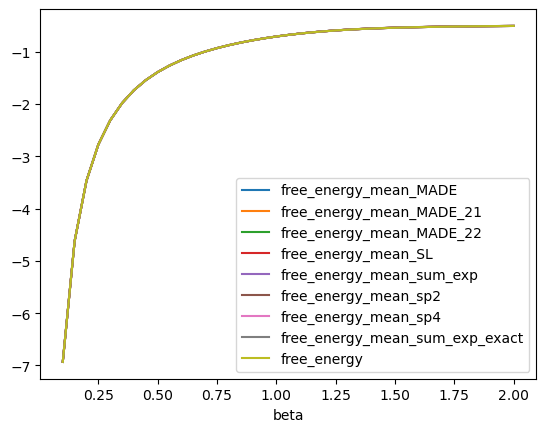

In [28]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
kkk="free_energy_mean"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy")
data.plot(x="beta", y=namess)


<AxesSubplot:xlabel='beta'>

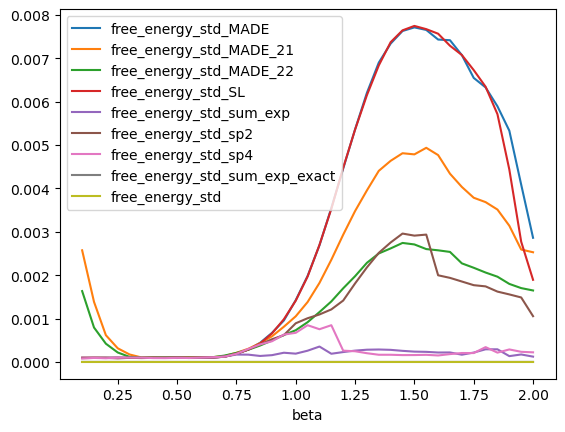

In [29]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
kkk="free_energy_std"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

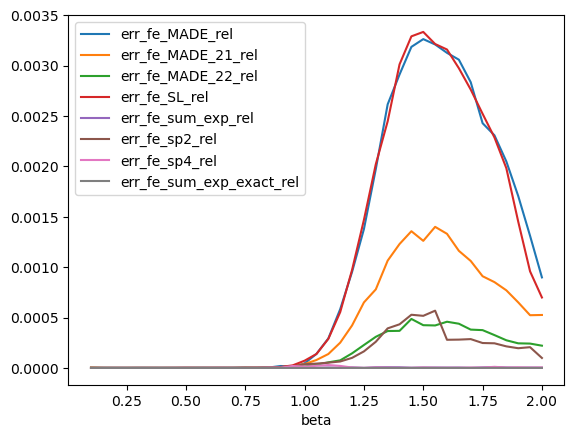

In [30]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

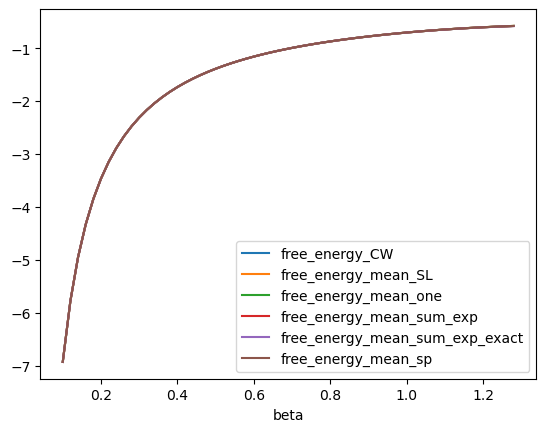

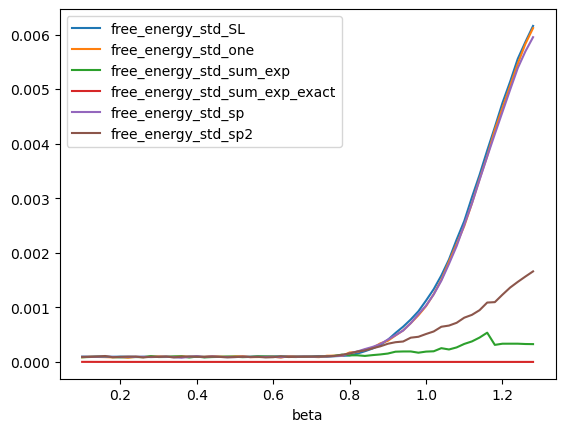

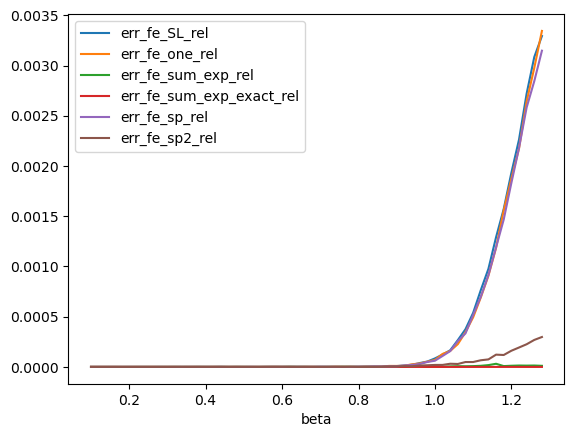

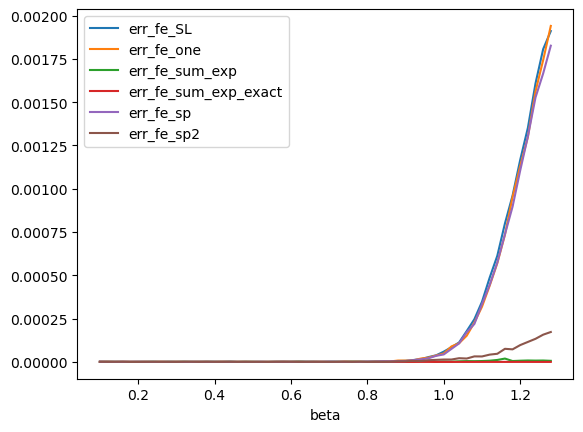

In [27]:

data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_one", "free_energy_std_sum_exp", "free_energy_std_sum_exp_exact","free_energy_std_sp","free_energy_std_sp2",]) #"free_energy_std_sp4"])
data.plot(x="beta", y=["err_fe_SL_rel", "err_fe_one_rel", "err_fe_sum_exp_rel", "err_fe_sum_exp_exact_rel","err_fe_sp_rel","err_fe_sp2_rel"])#,"err_fe_sp4_rel"])
data.plot(x="beta", y=["err_fe_SL", "err_fe_one", "err_fe_sum_exp", "err_fe_sum_exp_exact", "err_fe_sp", "err_fe_sp2"])# "err_fe_sp4"])

In [ ]:
data.plot(x="beta", y=["mag_mean", "mag_mean_CW", "mag_mean_SL", "mag_mean_one", "mag_mean_sum_exp", "mag_mean_sum_exp_exact"])


KeyError: "['mag_mean'] not in index"

In [129]:
data.plot(x="beta", y=["entropy_mean", "entropy_mean_SL", "entropy_mean_1V", "entropy_mean_SK", "entropy_mean_SK_exact"])


KeyError: "['entropy_mean', 'entropy_mean_1V', 'entropy_mean_SK', 'entropy_mean_SK_exact'] not in index"

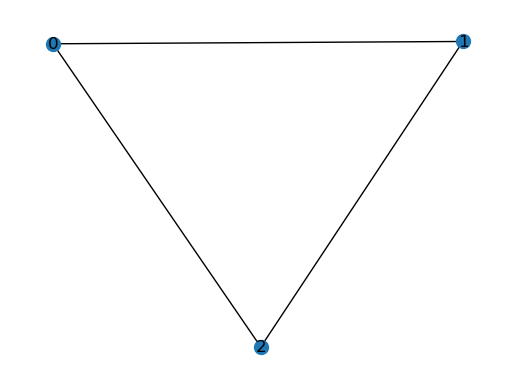

In [30]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

N = 3
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))

if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)
JJ=1
J_val = JJ/(2*N)
J = J_val * J_interaction


device="cpu"
#device="mps"
CW_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=1.3
beta_init = 0.1
step = 0.1
betas = np.arange(beta_init, beta_fin
, step)

In [31]:
from python_lib.nets import ann
importlib.reload(ann)
from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.long()
dict_nets = {}
net2train = list_nets.list_nets(CW_model, one, input_mask, device=device, dict_nets=dict_nets)

In [33]:
beta = 1
net2train.train(
    beta=beta,
    lr=lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit = 0.001,
    exact=True
)


step: 0 1.00 fe: -0.594 +- 0.24724 E: 0.069, S: 0.662, M: 0.397

{'beta': 1,
 'free_energy_mean': -0.5935537020365397,
 'free_energy_std': 0.2472420334815979,
 'entropy_mean': 0.6624425649642944,
 'energy_mean': 0.06888888776302338,
 'mag': array([ 0.001, -0.008,  0.034], dtype=float32),
 'mag_mean': 0.3966667056083679}

In [51]:
x, hx=net2train.sample(200000)
torch.abs(x.mean(-1)).mean(), x.mean(-1).mean()

(tensor(0.3982), tensor(0.0010))

In [54]:
i = 0
for nnet in net2train.net:
    print(f"ni: {i}")
    i+=1
    for name, param in nnet.named_parameters():
        print(name, param.data)


ni: 0
weight_p tensor([[ 0.3333,  0.0000, -0.3333]])
bias_p tensor([[1.0000, 0.6931, 0.3333]])
weight_m tensor([[ 0.3333,  0.0000, -0.3333]])
bias_m tensor([[0.3333, 0.6931, 1.0000]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 1
weight_p tensor([[ 0.1667, -0.1667]])
bias_p tensor([[0.3333, 0.0000]])
weight_m tensor([[ 0.1667, -0.1667]])
bias_m tensor([[0.0000, 0.3333]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 2
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])


In [198]:
m = x.sum(-1)
m

tensor([ 2., -6.])

In [205]:
weight_p = torch.tensor([[1,2,3,4]], device=device)

In [206]:
weight_p

tensor([[1, 2, 3, 4]])

In [208]:
res = weight_p * torch.unsqueeze(m, dim=1)
res

tensor([[  2.,   4.,   6.,   8.],
        [ -6., -12., -18., -24.]])

In [210]:
torch.logsumexp(res, 1)

tensor([ 8.1451, -5.9975])

In [ ]:
pd.__version__

In [ ]:
data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_1V"], ylim=(0, 0.1))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
all_Js = np.array(all_Js)

In [ ]:
plt.plot(stats_pd["beta"], all_Js[:,2])
plt.plot(stats_pd["beta"], all_Js[:,3])
plt.plot(stats_pd["beta"], all_Js[:,4])
plt.plot(stats_pd["beta"], all_Js[:,5])
plt.plot(stats_pd["beta"], all_Js[:,19])

In [ ]:
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
from python_lib.nets import simplest
from python_lib.solvers import train_nn_anneal
importlib.reload(simplest)
importlib.reload(solvers)
bias = True
net_simplest = simplest.simplest(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.nets import one_var
importlib.reload(one_var)
bias = True
net_one_var = one_var.one_var(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net_one_var
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd_est = pd.DataFrame(stats)
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd_est["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,0.)

ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"])/np.abs(f_exact))
ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"]))
    
ax2.plot(stats_pd_est["free_energy_std"])

In [ ]:
net_simplest.layer1.weight

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=100
batch_size=2000
stats = train_nn_anneal(
    net, 
    np.full(100, 0.0001),
    lr=lr, 
    max_step=5,
    batch_size=batch_size)
stats = train_nn_anneal(
    net, 
    betas,
    lr=lr, 
    max_step=max_step,
    batch_size=batch_size)
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd = pd.DataFrame(stats)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"])/np.abs(f_exact))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"]))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
stats_pd.keys()

In [ ]:
stats_pd[stats_pd["beta"]==0.2]

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(2,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(np.linspace(0.001,beta,100), f_exact)
ax0.set_ylim(-1.25,-0.7)

for b in np.linspace(0.001,beta,100):
    
err = [np.abs()]

In [ ]:
net.compute_stats(beta, batch_size=50000)

## random case

In [ ]:
from python_lib.nets import bp_nn
importlib.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.001, 
           max_step=1000,
               opt="adam")


In [ ]:
net_rand.compute_stat_is(beta, batch_size=10000)

# BP solution

In [ ]:
import bp_solver
importlib.reload(bp_solver)

bp_sol = bp_solver.BP_solver(tree_rand)

In [ ]:
beta

In [ ]:
bp_sol.converge(beta)